In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch

import seaborn as sns
# Set up some parameters for pretty plots
import matplotlib as mpl
sns.set_style('whitegrid')
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Colors & styles adjustments for better visibility on both backgrounds
text_and_line_color = '#808080'
plt.rcParams['text.color'] = text_and_line_color
plt.rcParams['axes.labelcolor'] = text_and_line_color
plt.rcParams['xtick.color'] = text_and_line_color
plt.rcParams['ytick.color'] = text_and_line_color
plt.rcParams['axes.edgecolor'] = text_and_line_color



In [2]:
#### Functions

# Define the training loss function (as defined earlier)
def training_loss_fn(S, T, Sigma):
    difference = S - T
    loss = difference @ Sigma @ difference/2
    return loss

# Define the validation loss function
def validation_loss_fn(S, T):
    difference = S - T
    return torch.dot(difference, difference)/2




def get_extreme_eigenvalues(matrix):
    """Returns the smallest and largest non-vanishing eigenvalues of the matrix."""
    eigenvalues, _ = torch.linalg.eigh(matrix)
    sorted_eigenvalues = torch.sort(eigenvalues)[0]
    
    non_vanishing_eigenvalues = sorted_eigenvalues[sorted_eigenvalues > 1e-5]
    
    if len(non_vanishing_eigenvalues) == 0:
        raise ValueError("All eigenvalues are vanishing!")
    
    min_eigenvalue = non_vanishing_eigenvalues[0]
    max_eigenvalue = non_vanishing_eigenvalues[-1]
    
    return min_eigenvalue, max_eigenvalue

def compute_optimal_hyperparameters(matrix):
    """
    Compute all optimal hyperparameters. 
    Following the wonderful Distil article "Why Momentum Really Works"
    (https://distill.pub/2017/momentum/)
    The only differnces are that when an L_2 norm is included: 
    1. The minimal eigenvalue is WD
    2. The maximal eigenvalue is WD+lamnda_max
    3. WD is chose such that the convergence rate is the same inn both cases
    """
    
    # eigenvalues
    min_eigenvalue, max_eigenvalue=get_extreme_eigenvalues(matrix)

    # Optimal weight decay
    WD = max_eigenvalue * min_eigenvalue / (max_eigenvalue - min_eigenvalue)
    
    # Learning rates without momentum
    LR_0 = 2 / (max_eigenvalue + min_eigenvalue)
    LR_WD = 2 / (max_eigenvalue + 2 * WD)
    
    # Learning rates with momentum
    LR_beta = (2 / (torch.sqrt(max_eigenvalue) + torch.sqrt(min_eigenvalue)))**2
    LR_beta_WD = (2 / (torch.sqrt(max_eigenvalue + WD) + torch.sqrt(WD)))**2
    
    # Optimal momentum values
    beta_0 = ((torch.sqrt(max_eigenvalue) - torch.sqrt(min_eigenvalue)) / 
              (torch.sqrt(max_eigenvalue) + torch.sqrt(min_eigenvalue)))**2
    beta_lam = ((torch.sqrt(max_eigenvalue + WD) - torch.sqrt(WD)) / 
                (torch.sqrt(max_eigenvalue + WD) + torch.sqrt(WD)))**2
    
    return {
        "WD": WD,
        "LR_0": LR_0,
        "LR_WD": LR_WD,
        "LR_beta": LR_beta,
        "LR_beta_WD": LR_beta_WD,
        "beta_0": beta_0,
        "beta_lam": beta_lam
    }

In [3]:
# Setting up random seeds for reproducibility
torch.manual_seed(98736)

# inits
n = 1000        # Dimension
q = 7/10        # Fraction of training data (N_tr=q*n)

# Initialize teacher vector and normalize it to 1
T = torch.randn(n)
T = T/torch.norm(T)


# Initialize student vector
Si = torch.nn.Parameter(torch.randn(n)/np.sqrt(q*n))

# Define runs parameters
num_runs = 100
epochs = 200

# Lists to store all loss histories for each run
loss_histories = {
    "no_WD_no_beta": [],
    "WD_no_beta": [],
    "no_WD_beta": [],
    "WD_beta": []
}


for run in tqdm.trange(num_runs):
    
    # Generate new data
    X = torch.randn(int(q*n), n)
    Sigma = X.T @ X / (q*n)
    
    # Compute optimal hyperparameters
    hyperparameters = compute_optimal_hyperparameters(Sigma)
    
    # Reset initial student vectors
    S_no_WD_no_beta = Si.clone().detach().requires_grad_(True)
    S_WD_no_beta = Si.clone().detach().requires_grad_(True)
    S_no_WD_beta = Si.clone().detach().requires_grad_(True)
    S_WD_beta = Si.clone().detach().requires_grad_(True)
    
    # Initialize optimizers with computed hyperparameters
    optimizer_no_WD_no_beta = torch.optim.SGD([S_no_WD_no_beta], lr=hyperparameters["LR_0"])
    optimizer_WD_no_beta = torch.optim.SGD([S_WD_no_beta], lr=hyperparameters["LR_WD"], weight_decay=hyperparameters["WD"])
    optimizer_no_WD_beta = torch.optim.SGD([S_no_WD_beta], lr=hyperparameters["LR_beta"], momentum=hyperparameters["beta_0"])
    optimizer_WD_beta = torch.optim.SGD([S_WD_beta], lr=hyperparameters["LR_beta_WD"], weight_decay=hyperparameters["WD"], momentum=hyperparameters["beta_lam"])
    
    # Track loss history for each method
    loss_histories_for_run = {
        "no_WD_no_beta": [validation_loss_fn(S_no_WD_no_beta, T).item()],
        "WD_no_beta": [validation_loss_fn(S_WD_no_beta, T).item()],
        "no_WD_beta": [validation_loss_fn(S_no_WD_beta, T).item()],
        "WD_beta": [validation_loss_fn(S_WD_beta, T).item()]
    }

    
    for epoch in range(epochs):
        for method, optimizer in zip(loss_histories.keys(), [optimizer_no_WD_no_beta, optimizer_WD_no_beta, optimizer_no_WD_beta, optimizer_WD_beta]):
            optimizer.zero_grad()
            S = {"no_WD_no_beta": S_no_WD_no_beta, "WD_no_beta": S_WD_no_beta, "no_WD_beta": S_no_WD_beta, "WD_beta": S_WD_beta}[method]
            
            # Forward pass
            loss = training_loss_fn(S, T, Sigma)

            
            # Backward pass
            loss.backward()
            
            # Optimizer step
            optimizer.step()
            
        
            
            # Append history
            loss_histories_for_run[method].append(validation_loss_fn(S, T).item())
                
    # Append loss histories for this run
    for method in loss_histories.keys():
        loss_histories[method].append(loss_histories_for_run[method])


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


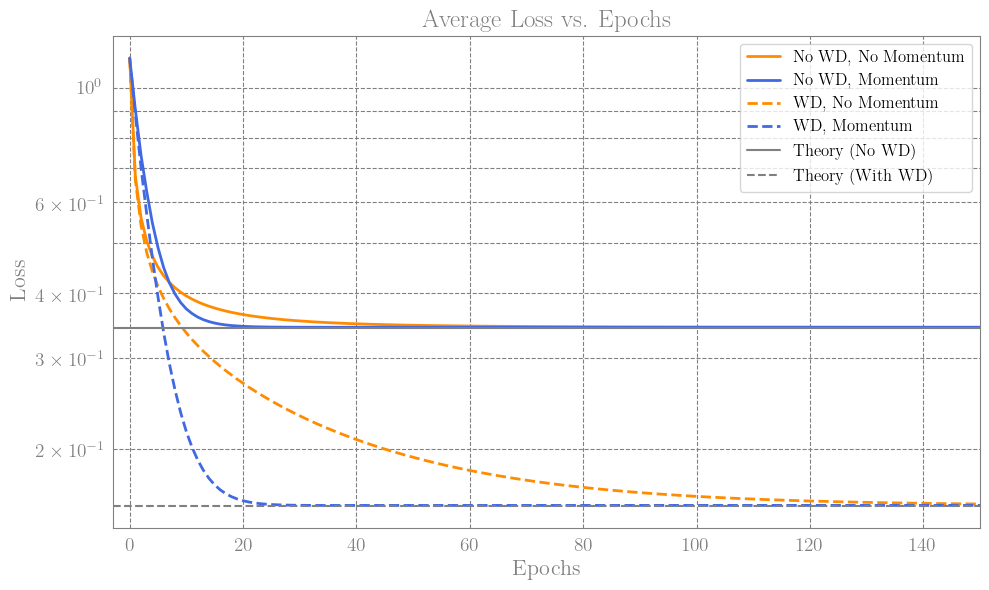

In [5]:
# Compute average loss histories over all runs
avg_loss_histories = {method: np.mean(loss_histories[method], axis=0) for method in loss_histories}


# Plot average loss histories
colors = {
    "no_WD_no_beta": "darkorange",
    "WD_no_beta": "darkorange",
    "no_WD_beta": "royalblue",
    "WD_beta": "royalblue"
}

linestyles = {
    "no_WD_no_beta": "-",
    "WD_no_beta": "--",
    "no_WD_beta": "-",
    "WD_beta": "--"
}

labels = {
    "no_WD_no_beta": r"No WD, No Momentum",
    "WD_no_beta": r"WD, No Momentum",
    "no_WD_beta": r"No WD, Momentum",
    "WD_beta": r"WD, Momentum"
}

plt.figure(figsize=(10, 6))

order = ["no_WD_no_beta", "no_WD_beta", "WD_no_beta", "WD_beta"]

for method in order:
    plt.semilogy(avg_loss_histories[method], label=labels[method], color=colors[method], linestyle=linestyles[method], linewidth=2)

plt.axhline((1-q) * ((Si - T) @ (Si - T)).item()/2, color=text_and_line_color, ls='-', label=r"Theory (No WD)")
plt.axhline((1-q)*1.03/2, color=text_and_line_color, ls='--', label=r"Theory (With WD)")

plt.title(r'Average Loss vs. Epochs')
plt.xlabel(r'Epochs')
plt.ylabel(r'Loss')
plt.xlim(-3,150)
leg = plt.legend(fontsize=12)
for text in leg.get_texts():
    text.set_color("black")
plt.grid(True, which="both", ls="--", c=text_and_line_color)
plt.tight_layout()

plt.savefig('/Users/nadavoutmezguine/Library/CloudStorage/Dropbox/Mac/Documents/Nadav-out.github.io/assets/images/gen_linear.png',dpi=300, bbox_inches='tight', transparent=True)

plt.show()

